### Downlowd dataset

In [1]:
import os
if 'data' not in os.listdir():
    os.makedirs("data")

## downlod data from web site
!gsutil cp gs://cartoonset_public_files/cartoonset10k.tgz /content/data/cartoonset10k.tgz

Copying gs://cartoonset_public_files/cartoonset10k.tgz...
| [1 files][454.6 MiB/454.6 MiB]                                                
Operation completed over 1 objects/454.6 MiB.                                    


In [ ]:
## dezip on the tmp dir
!tar -xzvf "/content/data/cartoonset10k.tgz" -C "/content/data/"

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import gdown
from zipfile import ZipFile

In [5]:
dataset = keras.preprocessing.image_dataset_from_directory(
    "/content/data", label_mode=None, image_size=(128, 128), batch_size=32
)

dataset = dataset.map(lambda x: x / 255.0)

Found 10000 files belonging to 3 classes.


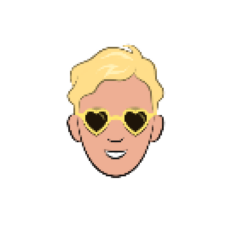

In [6]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

### Create the discriminator

In [7]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(128, 128, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        3136      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       131200    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 32768)           

### Create the generator

In [8]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(16 * 16 * 128),
        layers.Reshape((16, 16, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32768)             4227072   
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 128)       262272    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 64, 64, 256)       524544    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 64, 64, 256)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 128, 128, 512)     20

### Override train_step

In [9]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

### Create a callback that periodically saves generated images

In [38]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
         
    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("/content/data/generate_img/generated_img_%03d_%d.png" % (epoch, i))
        if epoch %2 == 0:
            gan.save_weights('/content/data/gan.h5')

### Train the end-to-end model

In [39]:
epochs = 50  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

history = gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/50
313/313 [==============================] - 176s 557ms/step - d_loss: 0.2822 - g_loss: 2.1882
Epoch 2/50
313/313 [==============================] - 176s 558ms/step - d_loss: 0.2177 - g_loss: 2.2260
Epoch 3/50
313/313 [==============================] - 176s 560ms/step - d_loss: 0.2213 - g_loss: 2.2518
Epoch 4/50
313/313 [==============================] - 176s 559ms/step - d_loss: 0.2075 - g_loss: 2.3115
Epoch 5/50
313/313 [==============================] - 176s 559ms/step - d_loss: 0.2135 - g_loss: 2.3629
Epoch 6/50
313/313 [==============================] - 176s 559ms/step - d_loss: 0.1985 - g_loss: 2.3973
Epoch 7/50
313/313 [==============================] - 176s 559ms/step - d_loss: 0.1961 - g_loss: 2.4551
Epoch 8/50
313/313 [==============================] - 176s 559ms/step - d_loss: 0.1987 - g_loss: 2.4824
Epoch 9/50
313/313 [==============================] - 176s 559ms/step - d_loss: 0.2063 - g_loss: 2.5105
Epoch 10/50
313/313 [==============================] - 176s 558m

In [40]:
history.history.keys()

dict_keys(['d_loss', 'g_loss'])

In [45]:
plt.style.use('ggplot')

def plot_history(history):
    d_loss = history.history['d_loss']
    g_loss = history.history['g_loss']
    x = range(1, len(d_loss) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, d_loss, 'b', label='d_loss')
    plt.plot(x, g_loss, 'r', label='g_loss')
    plt.title('g_loss and d_loss')
    plt.legend()
    

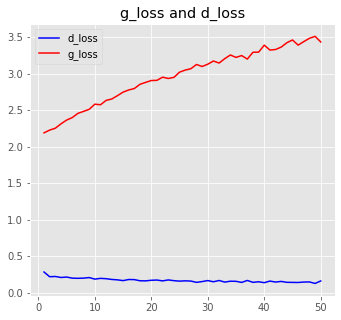

In [46]:
plot_history(history)